# Часть 1. Парсинг

Соберем данные с сайта https://dzen.ru/news/top/region/Moscow?issue_tld=ru. <br>В таблице отражаются 15 первых сюжетов новостей из топа Яндекс-новостей и статистика по ним.<br>ПВ таблицу добавлен столбец 'place', который показывает место новости в рейтинге.

In [25]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore") 

In [2]:
def get_stat_data():
    cookies = { # set up here your own yandex cookies 
        }

    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Accept-Language': 'ru,ru-RU;q=0.9',
        'Cache-Control': 'max-age=0',
        'Connection': 'keep-alive',
        # Requests sorts cookies= alphabetically
        # 'Cookie': 'nc=tips=1663061604787%3Bfavorites-button:1#search-visits-per-week=1:1665662757000; yandex_login=ksk1496; gdpr=0; _ym_uid=1663056123518611958; _ym_d=1663056123; sso_checked=1; Session_id=3:1663328297.5.0.1663328297717:oyulXw:16C.1.2:1|566202596.0.2|64:10003806.969334.nylHXnqjzYDpHUeeMcngawJGwBU; ys=udn.cDprc2sxNDk2#c_chck.1491327450; yandexuid=6356389931661544626; mda2_beacon=1663328297755; tmr_lvid=cd2befa5d9e2355ae7965265ed50d217; tmr_lvidTS=1663769907592; bltsr=1; crookie=e73r40jfJLEIKat91sFZcOf8WfDs5QFNV5TimgRlB780+t/oPlEEyB/FNGZTEEmeeEEjFgk5gOOKlwNl0cP8tJWGoB8=; cmtchd=MTY2NjI1NjkyOTIwMw==; KIykI=1; _yasc=VmzFOB935Ls1jsns8nQ990lGRv3FTOooP2H+MjIwgNssD0pWwgg5K5QzqTw=; _ym_isad=1; tmr_detect=0%7C1666698972628; tmr_reqNum=243',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'none',
        'Sec-Fetch-User': '?1',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36',
        'sec-ch-ua': '"Chromium";v="106", "Google Chrome";v="106", "Not;A=Brand";v="99"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"macOS"',
    }

    params = {
        'issue_tld': 'ru',
    }

    response = requests.get('https://dzen.ru/news/top/region/Moscow', params=params, cookies=cookies, headers=headers)
    soup = BeautifulSoup(response.text)
    data = []
    for row in soup.find('div', class_='news-top-table__content'):
        row_stat = row.find('div', class_='news-top-table__stat')
        instory_url = row_stat.find('a')['href'].replace('/story/', '/instory/')
        story_title = row_stat.find('a').text
        row_list = [item.text for item in row_stat.find_all('span', class_='news-top-table__stat-item')]
        story_id = int(re.search(r'(?<=persistent_id=)\d+', instory_url).group(0))
        row_list.insert(0, story_id)
        row_list.insert(1, instory_url)
        row_list.insert(2, story_title)
        data.append(row_list)

    dt_object = (datetime.now()).strftime('%d.%m.%Y %H:%M')

    df_stat = pd.DataFrame(data, columns=['story_id',                 # id_сюжета
                                          'instory_url',              # Ссылка
                                          'story_title',              # Название сюжета
                                          'story_docs_per_hour',      # Сообщений за час
                                          'story_docs_total_number',  # Документов в сюжете
                                          'number_stories_in_theme',  # Сюжетов в теме
                                          'docs_in_theme',            # Документов в теме
                                          'story_views',              # Просмотры сюжета
                                          'region_interest',          # Региональный интерес
                                          'story_weight',             # Вес сюжета
                                          'rubric'])                  # Рубрика

    df_stat['story_views'] = df_stat['story_views'].str.replace('%', '').astype(float, errors='ignore')
    df_stat['dt_now'] = dt_object
    df_stat['place'] = range(1, len(df_stat) + 1)
    return df_stat

# Часть 2. NLP

Вторая часть задания выполнена по отзывам на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('IMDB Dataset.csv')

In [8]:
# Функция для кодирования лейблов
def label2num(y):
    if y == 'positive':
        return 1
    if y == 'negative':
        return -1
    if y == 'neutral':
        return 0

encoded_y = [label2num(yy) for yy in df['sentiment']]

Предобработка текстов

In [10]:
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit

In [11]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# примеры стоп-слов
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kondratevask/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
# знаки препинания
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
stop_words.extend(['br'])

In [14]:
word_tokenizer = nltk.WordPunctTokenizer()

In [15]:
dates = [str(x) for x in np.arange(1900, 2022)]

In [16]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else " " for ch in text])

In [17]:
def process_data(data):
    texts = []
    targets = []
    for item in data:
        text = remove_punctuation(item)
        text_lower = text.lower() # приводим все слова к нижнему регистру
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем текст на слова
        
        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in stop_words and word not in dates)]
        
        texts.append(tokens) # добавляем в предобработанный список
    
    return texts

In [18]:
# запускаем нашу предобработку
texts = process_data(df['review'].to_list())

In [20]:
# Lemmatize

# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

# инициализируем лемматизатор :)
morph = pymorphy2.MorphAnalyzer()

In [26]:
# применяем лемматизацию ко всем текстам
for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    texts[i] = ' '.join(text_lemmatized)  

  0%|          | 0/50000 [00:00<?, ?it/s]

In [28]:
#train test_split
train_texts, test_texts, train_y, test_y = train_test_split(texts, encoded_y, 
                                                            test_size=0.2, 
                                                            random_state=42, 
                                                            stratify = df['sentiment'])

In [29]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(
#                             analyzer='word',
# #                             ngram_range=(1,2),
#                             min_df=0.2, 
#                             max_df=0.8,
#                             norm=None,)

# train_X = vectorizer.fit_transform(train_texts)
# test_X  = vectorizer.transform(test_texts)

In [33]:
train_X.shape, test_X.shape

((40000, 31), (10000, 31))

In [34]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(30, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [35]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
    color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
    color='red', label='test')
    plt.legend();

0.7516
grid_logit.best_params_{'logisticregression__C': 0.001}, grid_logit.best_score_0.7490000321854454


NameError: name 'model' is not defined

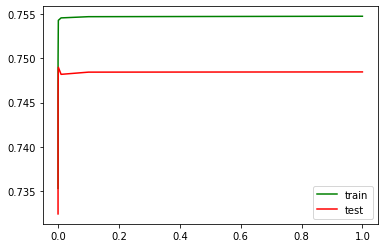

In [47]:
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(TfidfVectorizer(
                                                analyzer='char',
                                                ngram_range=(1,2),
                                                min_df=0.2, 
                                                max_df=0.8,
                                                norm=None), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(train_texts, train_y)
print(text_pipe_logit.score(test_texts, test_y))

from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True)

grid_logit.fit(train_texts, train_y)
print(f'grid_logit.best_params_{grid_logit.best_params_}, grid_logit.best_score_{grid_logit.best_score_}')
plot_grid_scores(grid_logit, 'logisticregression__C')
grid_logit.score(test_texts, test_y)

0.8987
grid_logit.best_params_{'logisticregression__C': 1.0}, grid_logit.best_score_0.8905499261150345


0.8987

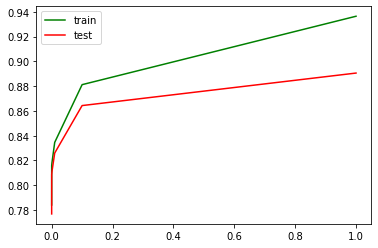

In [51]:
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(TfidfVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(train_texts, train_y)
print(text_pipe_logit.score(test_texts, test_y))

from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True)

grid_logit.fit(train_texts, train_y)
print(f'grid_logit.best_params_{grid_logit.best_params_}, grid_logit.best_score_{grid_logit.best_score_}')
plot_grid_scores(grid_logit, 'logisticregression__C')
grid_logit.score(test_texts, test_y)

# visualize_coefficients(model, vectorizer.get_feature_names(), n_top_features=50)

In [68]:
# создаем чистовую модель, учитывая лучшие параметры
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

logreg = LogisticRegression(C=1.0, n_jobs=-1, random_state=7)
logreg.fit(train_X, train_y)
logreg_pred = logreg.predict(test_X)

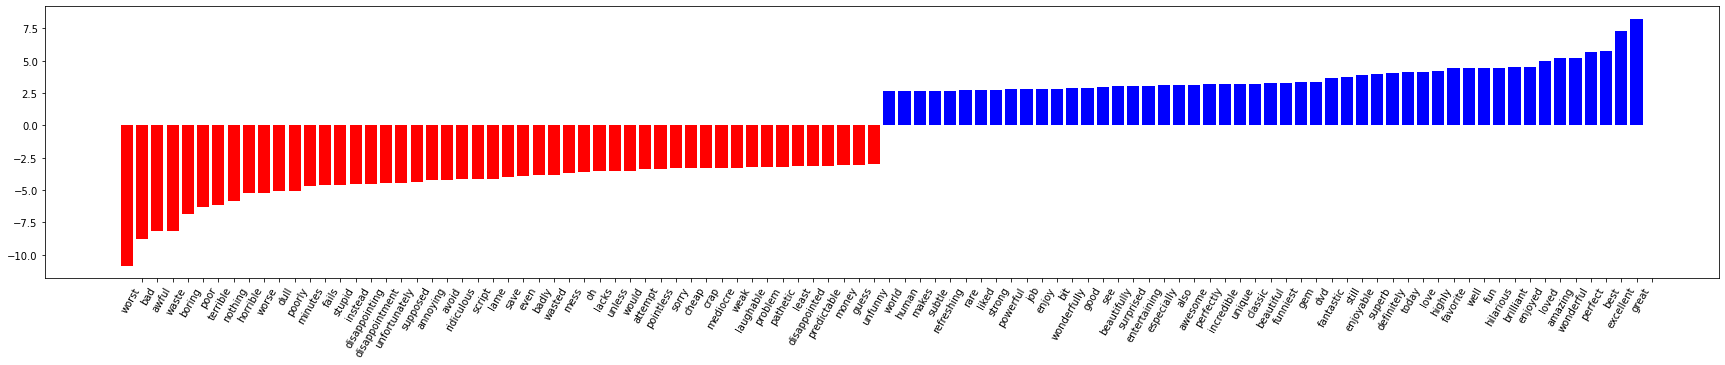

In [70]:
visualize_coefficients(logreg, vectorizer.get_feature_names(), n_top_features=50)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(test_y, logreg_pred))

              precision    recall  f1-score   support

          -1       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

